"파이썬 딥러닝 텐서플로우" 교재 중  
"part 04 합성곱 신경망(CNN) 04 위성 이미지 분류"에 대한 코드 정리

In [1]:
import tensorflow as tf
import numpy as np
import json
import matplotlib.pylab as plt

# tensorflow dataset 활용
import tensorflow_datasets as tfds

json 라이브러리가 무엇인지 궁금하면 아래 글을 참고하자.  
[json 라이브러리에 대한 설명](http://pythonstudy.xyz/python/article/205-JSON-%EB%8D%B0%EC%9D%B4%ED%83%80)  
사람과 기계가 쉽게 읽을 수 있는 데이터 포맷 중 하나라고 한다.

`ModuleNotFoundError: No module named 'tensorflow_datasets'`  
에러가 나타나면 아나콘다 내비게이터를 실행해서, tensorflow_datasets' 패키지를 설치해주자.  
근데 난 이걸로 해결 안됐음  
왜그런건지 모르겠는데 주피터노트북 커널 연결이 안되고 계속 연결 실패 오류 뜨길래 vsc로 와서 작업하니 된다 아놔

In [4]:
DATA_DIR = "dataset/"

(train_ds, valid_ds),info = tfds.load('eurosat/rgb', split=['train[:80%]', 'train[80%:]'],
                                     shuffle_files=True,
                                     as_supervised=True,
                                     with_info=True,
                                     data_dir=DATA_DIR)

print(train_ds)
print(valid_ds)

Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...: 100%|██████████| 1/1 [00:08<00:00,  8.26s/ url]

Dl Completed...: 100%|██████████| 1/1 [00:28<00:00, 28.74s/ url]


Dataset eurosat downloaded and prepared to dataset/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.
<_OptionsDataset shapes: ((64, 64, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((64, 64, 3), ()), types: (tf.uint8, tf.int64)>


In [5]:
print(info)

tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_path='dataset/eurosat/rgb/2.0.0',
    download_size=89.91 MiB,
    dataset_size=89.50 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disa

2022-02-19 06:59:17.978440: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-19 06:59:18.064550: W tensorflow/core/kernels/data/cache_dataset_ops.cc:757] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


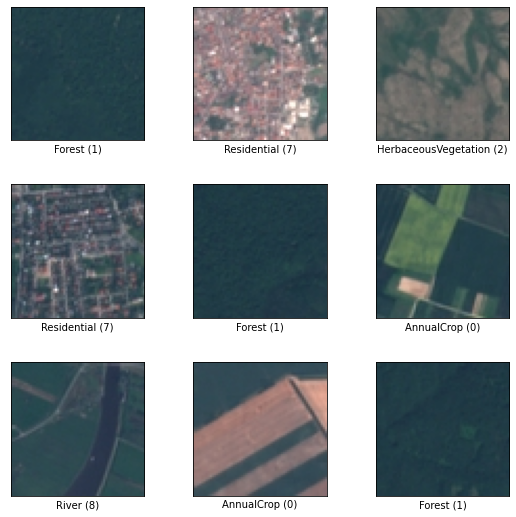

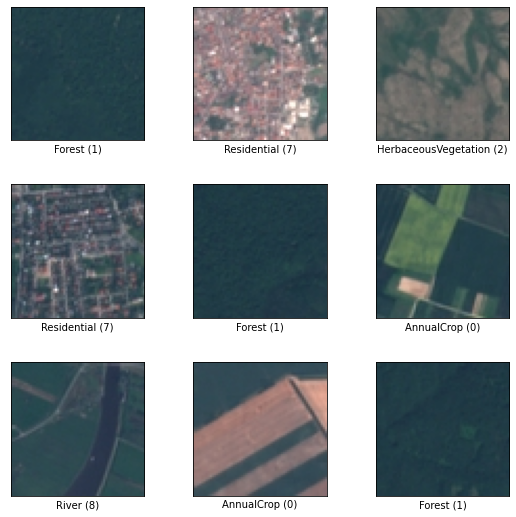

In [6]:
tfds.show_examples(train_ds, info)

2022-02-19 07:00:14.693178: W tensorflow/core/kernels/data/cache_dataset_ops.cc:757] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


,image,label
0,,5 (Pasture)
1,,7 (Residential)
2,,0 (AnnualCrop)
3,,1 (Forest)
4,,0 (AnnualCrop)
5,,2 (HerbaceousVegetation)
6,,9 (SeaLake)
7,,8 (River)
8,,2 (HerbaceousVegetation)
9,,9 (SeaLake)

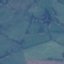
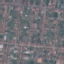
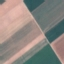
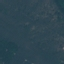
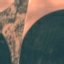
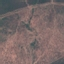
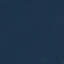
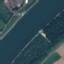
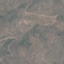
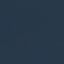

In [8]:
#as_dataframe 사용해서 샘플 출력
tfds.as_dataframe(valid_ds.take(10), info)

In [9]:
NUM_CLASSES = info.features["label"].num_classes
print(NUM_CLASSES)

10


In [10]:
#숫자 레이블을 활용해 문제열 메타 데이터로 변환한다.
#클래스 6 : 영구작물(Permanent Crop)을 의미
print(info.features["label"].int2str(6))

PermanentCrop


2. 데이터 전처리

In [13]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

def preprocess_data(image, label) :
    image = tf.cast(image, tf.float32) / 255.
    return image, label

train_data = train_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
valid_data = valid_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_data = valid_data.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)